# RNN Memory Capacity: How much information can it remember？
Final Project

Michael Bian

Intro to Deep Learning – FL25

Instructor: Alfredo Canziani



## 1. Conceptual question
When the distance between critical information and the prediction target increases, does the memory capacity of recurrent neural networks (RNNs) gradually decay or suddenly collapse?

Specifically: as the time interval (K) between critical contextual information and the prediction target in a sequence gradually increases, does the RNN's prediction performance gradually decline, or does a significant performance drop occur after reaching a certain critical distance K*?

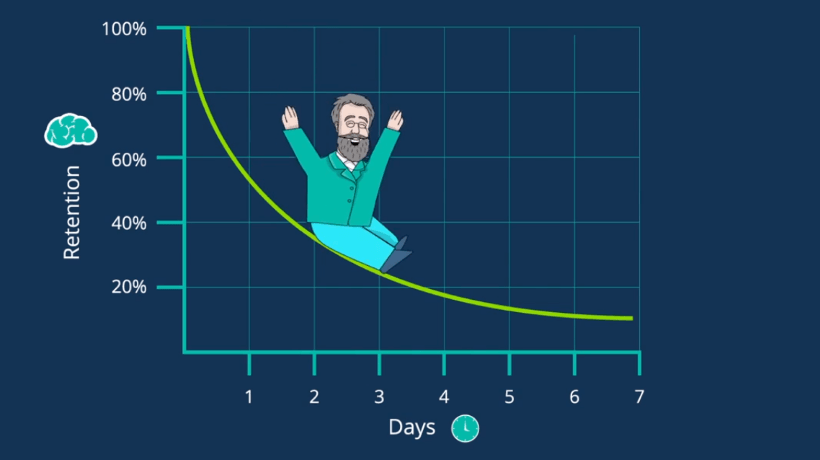

## 2. Hypothesis
1. The hidden state of an RNN has a limited effective memory capacity. When the time interval (denoted as K) between key contextual information and the prediction target exceeds a certain threshold K*, the model performance will show a non-linear, sudden decline, rather than a smooth, gradual decay. This phenomenon manifests as a "memory cliff," reflecting the capacity limitations of the hidden state as a finite-dimensional representation.

2. Increasing the dimensionality of the recurrent neural network's hidden layer can delay memory decay, but the resulting improvement in effective memory distance is not linear. That is, increasing the size of the hidden layer does not linearly extend the maximum manageable dependency distance K*, indicating that long-range dependencies are limited by the recursive structure itself, and not merely by the size of the representation dimension.

## 3. Experimental design
**What is being compared?**
- RNN performance at different memory distances K (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, 25)
- RNN performance with different hidden layer sizes (16, 32, 64, 128, 256)

**What is kept fixed?**
- Model architecture: single-layer RNN with ReLU activation
- Embedding dimension: 32
- Training iterations: 3000 (Experiment 1), 2000 (Experiment 2)
- Learning rate: 0.001
- Task type: Cloze task (predicting a word that appeared K steps earlier)
- Vocabulary and dataset: same cloze tasks for all experiments

**What is varied?**
- Memory distance K: the number of filler words between the key information and the prediction target
- Hidden layer size H: 16, 32, 64, 128, 256

**Why this experiment is sufficient to test the hypothesis:**
- The cloze test naturally measures memory capacity because the task inherently requires long-range memory of words; if the model forgets the keywords, it cannot predict correctly.
- By systematically varying the value of K, we can observe whether performance degrades gradually or collapses suddenly.
- By changing the hidden layer size, we can test whether memory capacity is linearly related to the representation dimension.
- Accuracy below the random baseline indicates complete forgetting, providing a clear threshold for memory failure.

## 4. Experiment code

# Setup


In [ ]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed to ensure the experiment is reproducible.
torch.manual_seed(1)
np.random.seed(3)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Cloze Task

Method

I designed a **cloze task** where the correct answer depends on information K steps prior.

Example:
> “People send gifts or **greeting cards** to wish each other a Merry Christmas… <blank>”
>
> If the model forgets "greeting cards," it cannot predict correctly.

This makes accuracy a direct measure of memory capacity: **incorrect answer = forgetting**.

In [ ]:
# Cloze Task Data: Real Sentences with Long-Range Dependencies
# From https://bogglesworldesl.com/cloze_activities.htm

# Each entry (task) has a context, prefix (input up to blank), and answer
# These are some sentences with long-range dependencies, need the context of entire sentence
CLOZE_TASKS = [
    {
        "context": "the chef added salt and pepper to the soup then he stirred the pot and tasted the soup",
        "prefix": "the chef added salt and pepper to the soup then he stirred the pot and tasted the",
        "answer": "soup"
    },
    {
        "context": "the storm brought heavy rain and strong winds many trees fell down because of the winds",
        "prefix": "the storm brought heavy rain and strong winds many trees fell down because of the",
        "answer": "winds"
    },
    {
        "context": "the dog chased the cat across the yard the cat climbed up a tree to escape the dog",
        "prefix": "the dog chased the cat across the yard the cat climbed up a tree to escape the",
        "answer": "dog"
    },
    {
        "context": "the teacher gave the students a difficult test many students failed the test",
        "prefix": "the teacher gave the students a difficult test many students failed the",
        "answer": "test"
    },
    {
        "context": "she went to the store to buy some milk but the store was closed so she went home without the milk",
        "prefix": "she went to the store to buy some milk but the store was closed so she went home without the",
        "answer": "milk"
    },
    {
        "context": "the player kicked the ball into the goal the crowd cheered for the goal",
        "prefix": "the player kicked the ball into the goal the crowd cheered for the",
        "answer": "goal"
    },
    {
        "context": "the musician played the piano beautifully everyone loved the sound of the piano",
        "prefix": "the musician played the piano beautifully everyone loved the sound of the",
        "answer": "piano"
    },
    {
        "context": "they took a train to the city the train was fast and comfortable",
        "prefix": "they took a train to the city the train was fast and",
        "answer": "comfortable"
    },
]



In [ ]:
# Build Vocabulary from All Cloze Tasks

# christmas is a holiday -> ["christmas", "is", "a", "holiday"]
def tokenize(text):
    text = text.lower()
    for c in '.,;:()[]{}!?\n\'"':
        text = text.replace(c, ' ')
    tokens = text.split()
    result = []
    for t in tokens:
        if len(t) > 0:
            result.append(t)
    return result

# Collect all words, now we combined our Cloze tasks together to build the corpus
corpus = []
for task in CLOZE_TASKS:
    words = tokenize(task["context"])
    for w in words:
        corpus.append(w)
    corpus.append(task["answer"])

# Build vocabulary, now we add this <blank> token, distinguished from regular <b>, to represent the cloze fill point,
# where model should gguess the answer (where we are looking for model's response)
BLANK_TOKEN = '<blank>'
unique_words = list(set(corpus))
unique_words.sort()
vocab = unique_words + [BLANK_TOKEN]

# Word to index
word_idx_dict = {}
for i in range(len(vocab)):
    word_idx_dict[vocab[i]] = i

def get_word_by_idx(idx):
    for word in word_idx_dict:
        if word_idx_dict[word] == idx:
            return word
    return None

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 75


# Preprocessing

In [ ]:
# For our RNN, generate the input sequence - a cloze sentence with K dependency length between context and BLANK.
# Structure: [prefix] + [K Distance Words] + [BLANK]
# For our task, K is the memory distance that the moel need to catch/overcome.
def generate_sequence(K):
    # Select from our task database
    selected_task = np.random.randint(len(CLOZE_TASKS))
    task = CLOZE_TASKS[selected_task]
    prefix_words = tokenize(task["prefix"])
    answer = task["answer"]

    # add K distance words, which is not actually empty word but we randomly select from the entire corpus
    distance_words = []
    for i in range(K):
        random_word = np.random.randint(len(corpus))
        distance_words.append(corpus[random_word])

    final_sequence_words = prefix_words + distance_words + [BLANK_TOKEN]

    final_sequence_idx = []
    for word in final_sequence_words:
        final_sequence_idx.append(word_idx_dict[word])

    x = final_sequence_idx[:-1]
    y = final_sequence_idx[1:] # target, move one to the left, next-token prediction
    y[-1] = word_idx_dict[answer] # set the "blank" in target to be the correct answer

    # nn Embedding
    x = torch.tensor(x, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)

    return x, y, answer


# RNN

In [ ]:
# Model: Standard Single-Layer RNN
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, output_size):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=rnn_hidden_size,
            num_layers=1,
            nonlinearity='relu',
            batch_first=True
        )
        self.linear = nn.Linear(
            in_features=rnn_hidden_size,
            out_features=output_size
        )

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.rnn(x, hidden)
        x = self.linear(x)
        return x, hidden

In [ ]:
# Training
# x -> Embedding vector -> hidden representation -> softargmax -> onehot (target)
def train(K, embed_dim, rnn_hidden_size, num_iters, lr):
    model = SimpleRNN(len(vocab), embed_dim, rnn_hidden_size, len(vocab))
    model = model.to(device)
    C = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=lr)

    model.train()
    total_loss = 0

    # Stochastic Gradient Descent, each data sample (sentence/task) individually contribute
    for i in range(num_iters):
        x, y, _ = generate_sequence(K)
        x = x.unsqueeze(0).to(device)
        y = y.to(device)

        # 5 steps:
        logits, _ = model(x, None)           # 1. generate prediction
        logits = logits.squeeze(0)
        loss = C(logits, y)                  # 2. compute loss
        optimiser.zero_grad()                # 3. zero gradients
        loss.backward()                      # 4. backprop
        optimiser.step()                     # 5. update params

        total_loss = total_loss + loss.item()

        if (i + 1) % 500 == 0:
            avg = total_loss / (i + 1)
            print("Iter %d/%d, Loss: %.4f" % (i+1, num_iters, avg))

    return model



# Evaluation
def evaluate(model, K, num_tests):
    model.eval()
    correct = 0
    preds = []
    targets = []

    with torch.no_grad():
        for i in range(num_tests):
            x, y, answer = generate_sequence(K)
            x = x.unsqueeze(0).to(device)

            hidden = None
            logits, hidden = model(x, hidden)
            logits = logits.squeeze(0)
            # Take the last position and find the word with the highest score, this is the model's decision
            pred_idx = logits[-1].argmax().item()
            target_idx = word_idx_dict[answer]
            # Check if prediction is the target answer
            if pred_idx == target_idx:
                correct = correct + 1

            preds.append(get_word_by_idx(pred_idx))
            targets.append(answer)

    acc = correct / num_tests
    return acc, preds, targets


In [ ]:
# Examples of how our sequences looks
for K in [0, 5, 10]:
    x, y, answer = generate_sequence(K)
    words = []
    for i in range(len(x)):
        words.append(get_word_by_idx(x[i].item()))
    print("")
    print("K=%d: ...%s <BLANK>" % (K, ' '.join(words[-12:])))
    print("      Answer: '%s'" % answer)


K=0: ...across the yard the cat climbed up a tree to escape the <BLANK>
      Answer: 'dog'

K=5: ...he stirred the pot and tasted the and the brought musician piano <BLANK>
      Answer: 'soup'

K=10: ...of the kicked winds was the added a was milk she goal <BLANK>
      Answer: 'piano'


# Experiment 1
Find K* (the critical point where accuracy drops to random levels)

In [ ]:
# Run Experiment 1

print("Experiment1: RNN Memory Capacity via Cloze Task")

all_answers = []
for task in CLOZE_TASKS:
    if task["answer"] not in all_answers:
        all_answers.append(task["answer"])

# random guess accuracy, differentiate if model actually learned it
random_baseline = 1.0 / len(all_answers)
print("Random baseline: %.1f%%" % (random_baseline * 100))

K_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, 25]
# hyperparameter
embed_dim = 32
rnn_hidden_size = 64
num_iters = 3000
num_tests = 500
lr = 0.001

print("Testing K values:", K_values)
print("Embedding vector dimension:", embed_dim)
print("Hidden layer size:", rnn_hidden_size)

# Store for each K value's result
results_K = []
results_acc = []

# Start our experiment
for K in K_values:
    print()
    print("Distance word K = ", K)
    print()

    print("Training...")
    model = train(K, embed_dim, rnn_hidden_size, num_iters, lr)

    print("Evaluating...")
    acc, preds, targets = evaluate(model, K, num_tests)

    print()
    acc_percent = acc * 100
    print("Accuracy for K =", K, "is", round(acc_percent, 1), "%")
    print("Sample predictions:")
    for i in range(5):
        if preds[i] == targets[i]:
            status = "correct"
        else:
            status = "wrong"
        print("Pred: '%s', Target: '%s' [%s]" % (preds[i], targets[i], status))

    results_K.append(K)
    results_acc.append(acc)

Experiment1: RNN Memory Capacity via Cloze Task
Random baseline: 12.5%
Testing K values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, 25]
Embedding vector dimension: 32
Hidden layer size: 64

Distance word K =  0

Training...
Iter 500/3000, Loss: 1.1035
Iter 1000/3000, Loss: 0.6050
Iter 1500/3000, Loss: 0.4358
Iter 2000/3000, Loss: 0.3521
Iter 2500/3000, Loss: 0.3014
Iter 3000/3000, Loss: 0.2673
Evaluating...

Accuracy for K = 0 is 100.0 %
Sample predictions:
Pred: 'soup', Target: 'soup' [correct]
Pred: 'test', Target: 'test' [correct]
Pred: 'test', Target: 'test' [correct]
Pred: 'piano', Target: 'piano' [correct]
Pred: 'goal', Target: 'goal' [correct]

Distance word K =  1

Training...
Iter 500/3000, Loss: 1.4748
Iter 1000/3000, Loss: 0.9615
Iter 1500/3000, Loss: 0.7778
Iter 2000/3000, Loss: 0.6822
Iter 2500/3000, Loss: 0.6221
Iter 3000/3000, Loss: 0.5815
Evaluating...

Accuracy for K = 1 is 100.0 %
Sample predictions:
Pred: 'milk', Target: 'milk' [correct]
Pred: 'goal', Target

Analysis:

1. Capacity Limit: K* = 4

2. Result Table:
K        Accuracy     vs Random    Status         
0        100.0       % 8.0         x Strong         
1        100.0       % 8.0         x Strong         
2        99.8        % 8.0         x Strong         
3        97.4        % 7.8         x Strong         
4        19.8        % 1.6         x Weak           
5        0.0         % 0.0         x Forgotten      
6        0.0         % 0.0         x Forgotten      
7        0.0         % 0.0         x Forgotten      
8        0.0         % 0.0         x Forgotten      
10       0.0         % 0.0         x Forgotten      
12       0.0         % 0.0         x Forgotten      
14       0.0         % 0.0         x Forgotten      
16       0.0         % 0.0         x Forgotten      
18       0.0         % 0.0         x Forgotten      
20       0.0         % 0.0         x Forgotten      
25       0.0         % 0.0         x Forgotten      



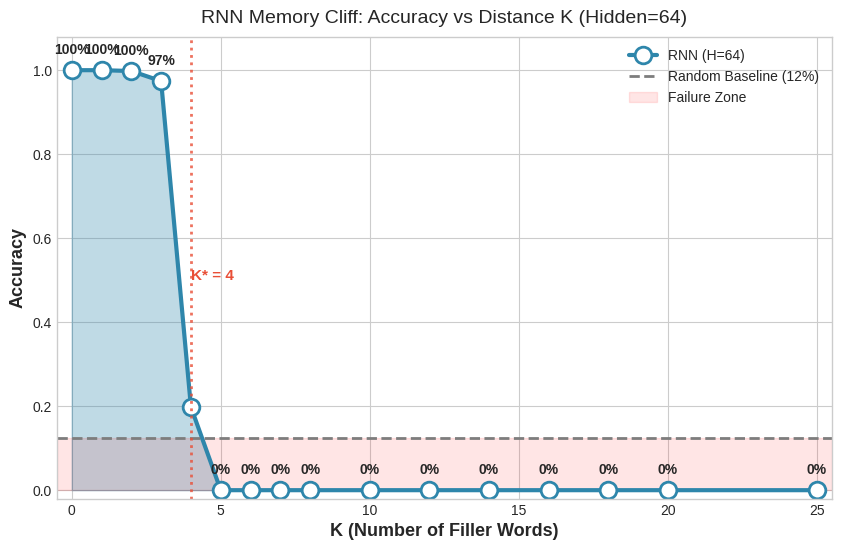

In [ ]:
# Analysis

print("Analysis:")

# find capacity limit
capacity_limit = None
for i in range(len(results_K)):
    if results_acc[i] < 0.3:
        capacity_limit = results_K[i]
        break

print()
print("1. Capacity Limit: K* = %s" % str(capacity_limit))

# results table
print()
print("2. Result Table:")
print("%-8s %-12s %-12s %-15s" % ("K", "Accuracy", "vs Random", "Status"))

for i in range(len(results_K)):
    k = results_K[i]
    acc = results_acc[i]
    vs_random = acc / random_baseline

    if acc >= 0.6:
        status = "Strong"
    elif acc >= 0.4:
        status = "Medium"
    elif acc >= random_baseline * 1.5:
        status = "Weak"
    else:
        status = "Forgotten"

    print("%-8d %-12.1f%% %-12.1fx %-15s" % (k, acc*100, vs_random, status))

# Plot
print()
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

main_color = '#2E86AB'
highlight_color = '#E94F37'
baseline_color = '#7D7D7D'

ax.fill_between(results_K, results_acc, alpha=0.3, color=main_color)
ax.plot(results_K, results_acc, 'o-', color=main_color, linewidth=3, markersize=12,
        markerfacecolor='white', markeredgewidth=2, label='RNN (H=%d)' % rnn_hidden_size)
ax.axhline(y=random_baseline, color=baseline_color, linestyle='--', linewidth=2,
           label='Random Baseline (%.0f%%)' % (random_baseline*100))
ax.axhspan(0, random_baseline, alpha=0.1, color='red', label='Failure Zone')

ax.set_xlabel('K (Number of Filler Words)', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('RNN Memory Cliff: Accuracy vs Distance K (Hidden=%d)' % rnn_hidden_size, fontsize=14, pad=10)
ax.set_ylim(-0.02, 1.08)
ax.set_xlim(min(results_K)-0.5, max(results_K)+0.5)
ax.legend(loc='upper right', framealpha=0.9)

for i in range(len(results_K)):
    if results_acc[i] > 0.5 or results_acc[i] < random_baseline * 1.5:
        ax.annotate('%.0f%%' % (results_acc[i]*100),
                    (results_K[i], results_acc[i]),
                    textcoords="offset points", xytext=(0, 12),
                    ha='center', fontsize=10, fontweight='bold')

if capacity_limit is not None:
    ax.axvline(x=capacity_limit, color=highlight_color, linestyle=':', linewidth=2, alpha=0.8)
    ax.annotate('K* = %d' % capacity_limit,
                xy=(capacity_limit, 0.5), fontsize=11, color=highlight_color,
                ha='left', fontweight='bold')

plt.show()

# Experiment 2

Test whether larger hidden layer sizes help

Experiment 2: Effect of Hidden Size on Memory Capacity

Hypothesis: Larger hidden size -> Longer memory span
Testing hidden size H = 16
Training K=0... Iter 500/2000, Loss: 2.3920
Iter 1000/2000, Loss: 1.3386
Iter 1500/2000, Loss: 0.9333
Iter 2000/2000, Loss: 0.7253
Acc: 100.0%
Training K=1... Iter 500/2000, Loss: 2.7355
Iter 1000/2000, Loss: 1.8412
Iter 1500/2000, Loss: 1.4390
Iter 2000/2000, Loss: 1.2198
Acc: 79.0%
Training K=2... Iter 500/2000, Loss: 3.0564
Iter 1000/2000, Loss: 2.2335
Iter 1500/2000, Loss: 1.8505
Iter 2000/2000, Loss: 1.6347
Acc: 21.0%
Training K=3... Iter 500/2000, Loss: 3.0211
Iter 1000/2000, Loss: 2.3304
Iter 1500/2000, Loss: 1.9894
Iter 2000/2000, Loss: 1.7915
Acc: 2.0%
Training K=4... Iter 500/2000, Loss: 3.2433
Iter 1000/2000, Loss: 2.6174
Iter 1500/2000, Loss: 2.2771
Iter 2000/2000, Loss: 2.0717
Acc: 1.0%
Training K=5... Iter 500/2000, Loss: 3.3098
Iter 1000/2000, Loss: 2.7184
Iter 1500/2000, Loss: 2.4225
Iter 2000/2000, Loss: 2.2475
Acc: 2.5%
Training K=6..

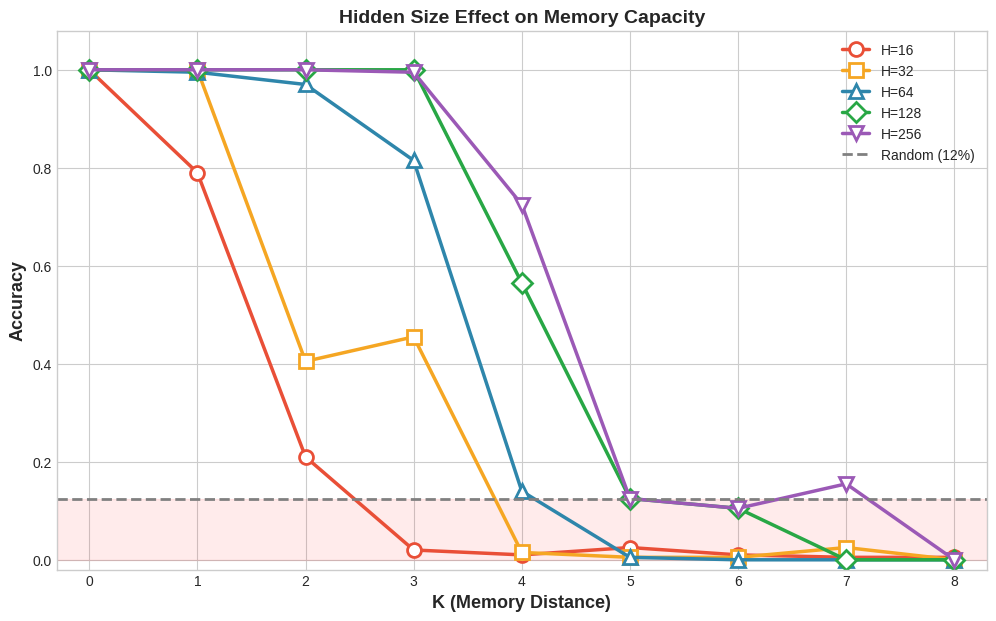



Summary: Hidden Size vs Capacity Limit
Hidden Size     K* (Capacity)  
16              2              
32              4              
64              4              
128             5              
256             5              

ANALYSIS:
Hidden size doubles: 16 -> 32 -> 64 -> 128 -> 256
But K* only increases: 2 -> 4 -> 4 -> 5 -> 5

In [ ]:
# Experiment 2: Hidden Size vs Memory Capacity
print("Experiment 2: Effect of Hidden Size on Memory Capacity")
print()
print("Hypothesis: Larger hidden size -> Longer memory span")

# Test different hidden sizes
hidden_sizes = [16, 32, 64, 128, 256]
K_test = [0, 1, 2, 3, 4, 5, 6, 7, 8]
num_iters_exp2 = 2000

# Store results for each hidden size
all_curves = {}

for H in hidden_sizes:
    print("Testing hidden size H =", H)

    curve_acc = []

    for K in K_test:
        print("Training K=%d..." % K, end=" ")
        model = train(K, embed_dim, H, num_iters_exp2, lr)
        acc, _, _ = evaluate(model, K, 200)
        curve_acc.append(acc)
        print("Acc: %.1f%%" % (acc * 100))

    all_curves[H] = curve_acc

    # find K* for this hidden size
    k_star = None
    for i in range(len(K_test)):
        if curve_acc[i] < 0.3:
            k_star = K_test[i]
            break
    print("Capacity limit K* =", k_star)

# Plot comparison
print()
print("Generating comparison plot...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Enough colors and markers for many hidden sizes
colors = ['#E94F37', '#F5A623', '#2E86AB', '#28A745', '#9B59B6', '#1ABC9C', '#E74C3C', '#3498DB']
markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '*']

for i in range(len(hidden_sizes)):
    H = hidden_sizes[i]
    curve = all_curves[H]
    c = colors[i % len(colors)]
    m = markers[i % len(markers)]
    ax.plot(K_test, curve,
            marker=m,
            color=c,
            linewidth=2.5,
            markersize=10,
            markerfacecolor='white',
            markeredgewidth=2,
            label='H=%d' % H)

ax.axhline(y=random_baseline, color='gray', linestyle='--', linewidth=2,
           label='Random (%.0f%%)' % (random_baseline*100))
ax.axhspan(0, random_baseline, alpha=0.08, color='red')

ax.set_xlabel('K (Memory Distance)', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Hidden Size Effect on Memory Capacity', fontsize=14, fontweight='bold')
ax.set_ylim(-0.02, 1.08)
ax.set_xlim(-0.3, max(K_test) + 0.3)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.show()

print()

# Summary table
print()
print("Summary: Hidden Size vs Capacity Limit")
print("%-15s %-15s" % ("Hidden Size", "K* (Capacity)"))

k_star_list = []
for H in hidden_sizes:
    curve = all_curves[H]
    k_star = max(K_test) + 1
    for i in range(len(K_test)):
        if curve[i] < 0.3:
            k_star = K_test[i]
            break
    k_star_list.append(k_star)
    if k_star > max(K_test):
        print("%-15d %-15s" % (H, ">" + str(max(K_test))))
    else:
        print("%-15d %-15d" % (H, k_star))

# Check if K* increases linearly with H
print()
print("ANALYSIS:")
print("Hidden size doubles: 16 -> 32 -> 64 -> 128 -> 256")
print("But K* only increases: ", end="")
for i in range(len(k_star_list)):
    if i > 0:
        print(" -> ", end="")
    print("%d" % k_star_list[i], end="")


# Conclusion

This project investigates the memory capacity of recurrent neural networks  through a cloze test task.
Main findings:
RNNs have a hard memory limit (K*). Beyond K*, accuracy drops sharply to random levels—not a gradual decay, but a precipitous decline.

K* grows logarithmically with the hidden layer size. Doubling the hidden layer size only increases K by approximately 1. This means that expanding parameters is inefficient.

Why? From h_t = W_hh @ h_{t-1}, it can be seen that information decays at a rate of λ^K (exponential decay). K* is the point where the signal strength falls below a threshold. The signal gradually decreases, but the model's performance doesn't degrade gradually. As long as the signal is strong enough, it can provide the correct answer; once the signal becomes too weak to be distinguished from noise, it collapses instantly.

Attention mechanisms solve this problem by directly accessing all past positions (Q @ K), bypassing the bottleneck of the hidden state.
Conclusion: The hidden state is an information bottleneck. This explains why  attention mechanisms (direct access) were invented.